In [1]:
from IPython.core.display import HTML
with open('../style.css') as f:
    css = f.read()
HTML(css)

# Local Search

## Utility Functions

The module `extractVariables` implements the function $\texttt{extractVars}(e)$ that takes a *Python* expression $e$ as its argument and returns the set of all variables and function names occurring in $e$.

In [2]:
import extractVariables as ev

The function `collect_variables(expr)` takes a string `expr` that can be interpreted as a Python expression as input and collects all variables occurring in `expr`.  It takes care to eliminate the function symbols from the names returned by `extract_variables`.

In [3]:
def collect_variables(expr):
    return frozenset(var for var in ev.extractVars(expr)
                         if  var not in dir(__builtins__)
                         if  var not in ['and', 'or', 'not']
                    )

The function `arb(S)` takes a set `S` as input and returns an arbitrary element from 
this set.

In [4]:
def arb(S):
    for x in S:
        return x

We need the function `choice` from the module `random`.  Given a list `L`, `random.choice(L)` returns a random element from `L`.  In order to have reproducible results, we have to set the seed for the random number generator.

In [5]:
import random
random.seed(42)

Given a dictionary `A`, the function `extend(A)` returns a dictionary `B` such that `B[key] = value` and `B[x] = A[x]` for all `x` that are different from `key`.

In [6]:
def extend(A, key, value):
    B = A.copy()
    B[key] = value
    return B

The module `Set` implements <em style="color:blue;">sets</em> as 
<a href="https://en.wikipedia.org/wiki/AVL_tree">AVL trees</a>.
The API provided by `Set` offers the following functions and methods:
- `Set()` creates an empty set.
- `S.isEmpty()` checks whether the set `S`is empty.
- `S.member(x)` checks whether `x` is an element of the set `S`.
- `S.insert(x)` inserts `x` into the set `S`.
  This does not return a new set but rather modifies the set `S`.
- `S.delete(x)` deletes `x` from the set `S`.
  This does not return a new set but rather modifies the set `S`.
- `S.pop()` returns the smallest element of the set `S`.
  Furthermore, this element is removed from `S`.
- `S.pop_last()` returns the biggest element of the set `S`.
  Furthermore, this element is removed from `S`.
- `S.first()` returns the smallest element of the set `S`.
- `S.last()` returns the biggest element of the set `S`.

Since sets are implemented as <em style="color:blue;">ordered binary trees</em>, the elements of a set need to be <em style="color:blue;">comparable</em>, i.e. if `x` and `y` are inserted into a set, then the 
expression `x < y` must return a Boolean value and `<` has to define a 
<em style="color:blue;">linear order</em>.

The module `Set` can be used to implement a priority queue that supports the removal of elements.

In [7]:
import sys
sys.path.append('..')
import Set

The function `cast_to_set(L)` returns a `Set` object containing all elements from the iterable `L`. 

In [8]:
def cast_to_Set(L):
    Result = Set.Set()
    for x in L:
        Result.insert(x)
    return Result

Given a list of sets `L`, the function `union(L)` returns the set of all elements occurring in some set $S$ that is itself a member of the list `L`, i.e. we have
$$ \texttt{union}(L) = \{ x \mid \exists S \in L : x \in L \}. $$ 

In [9]:
def union(L):
    return { x for S in L for x in S }

We define the class `Failure` of exceptions so that we can distinguish `Failure` exceptions from other exceptions.  This is done by creating a new, empty class that is derived from the class `Exception`.  

In [10]:
class Failure(Exception):
    pass

## A Constraint Problem Solver Using Local Search

The procedure `solve(P, consistency)` takes a *constraint satisfaction problem* 
`P` and a flag `consistency` as input.  Here `P` is a triple of the form 
$$ \mathcal{P} = \langle \mathtt{Variables}, \mathtt{Values}, \mathtt{Constraints} \rangle $$
where 
- $\mathtt{Variables}$ is a set of strings which serve as *variables*,
- $\mathtt{Values}$ is a set of *values* that can be assigned 
  to the variables in the set $\mathtt{Variables}$.
- $\mathtt{Constraints}$ is a set of *formulas* from first order logic.  
  Each of these formulas is  called a *constraint* of $\mathcal{P}$.
  
The CSP `P` is solved using *local search*.  If `consistency` is `True`, *consistency checking* is used as a 
preprocessing step. 

In [11]:
def solve(P, consistency=True):
    Variables, Values, Constraints = P
    VarsInConstrs  = union([ collect_variables(f) for f in Constraints ])
    MisspelledVars = (VarsInConstrs - Variables) | (Variables - VarsInConstrs)
    if len(MisspelledVars) > 0:
        print("Did you misspell any of the following Variables?")
        for v in MisspelledVars:
            print(v)
    ValuesPerVar = { x: Values for x in Variables }
    Annotated    = { f: collect_variables(f) for f in Constraints }
    if consistency:
        Connected    = {}
        Var2Formulas = variables_2_formulas(Annotated)
        for x in Variables:
            Connected[x] = union([ V for f, V in Annotated.items() if x in V ]) - { x }
        try:
            enforce_consistency(ValuesPerVar, Var2Formulas, Annotated, Connected)
            for x, Values in ValuesPerVar.items():
                print(f'{x}: {Values}')
        except Failure:
            return None
    return local_search(Variables, ValuesPerVar, Annotated)

The function `local_search` takes three parameter.  
* `Variables` is the set of all variables occurring in the given *CSP*.
* `ValuesPerVar` is a dictionary.  For every variable `x`, `ValuesPerVar[x]` is
   the set of values that can be used to instantiate `x`.
* `Annotated` is a dictionary.  For every constraint $f$, $\texttt{Annotated}[f]$ is the set
   of variables occurring in $f$.

If the computation is successful, `local_search` returns a dictionary that encodes a solution of the
given *CSP* by mapping variables to values.  The algorithm applied works as follows:
* Initialize the values of the variables in $\texttt{Variables}$ randomly.  
* If all $\texttt{Constraints}$ are satisfied, return the current variable binding as a solution.
* For every  $x \in \texttt{Variables}$, count the number of *unsatisfied* constraints that involve the
  variable $x$. 
* Set $\texttt{maxNum}$ to be the maximum of these numbers, i.e. $\texttt{maxNum}$ is the maximal number of
  unsatisfied constraints for any variable.
* Compute the list $\texttt{FaultyVars}$ of those variables that have $\texttt{maxNum}$ unsatisfied constraints.
* Randomly choose a variable $x$ from the set $\texttt{FaultyVars}$.
* Find a value $d \in \texttt{ValuesPerVar[x]}$ such that by assigning $d$ to the variable $x$, the number of
  unsatisfied constraints for the variable $x$ is minimized.  
  If there is more than one value $d$ with this property, choose the value $d$ randomly from those values
  that minimize the number of unsatisfied constraints.
* Rinse and repeat until a solution is found.

In [12]:
def local_search(Variables, ValuesPerVar, Annotated):
    Variables  = list(Variables)  # convert to list for random.choice(Variables) to work 
    Assignment = { x: random.choice(list(ValuesPerVar[x])) for x in Variables }
    iteration  = 0
    lastVar    = arb(Variables)
    while True:
        Conflicts = [ (numConflicts(x, Assignment, Annotated), x) for x in Variables
                                                                  if  x != lastVar
                    ]
        maxNum, _ = Set.last(cast_to_Set(Conflicts))
        if maxNum == 0 and numConflicts(lastVar, Assignment, Annotated) == 0:      
            print(f'Number of iterations: {iteration}')
            return Assignment
        if iteration % 11 == 0:    # avoid infinite loop
            x = random.choice(Variables)
        else:     # choose var with max number of conflicts
            FaultyVars = [ var for (num, var) in Conflicts if  num == maxNum ]
            x = random.choice(FaultyVars)
        if iteration % 13 == 0:       # avoid infinite loop
            newVal = random.choice(list(ValuesPerVar[x])) 
        else:
            Conflicts  = [ (numConflicts(x, extend(Assignment, x, val), Annotated), val) 
                            for val in ValuesPerVar[x] 
                         ]
            minNum, _  = Set.first(cast_to_Set(Conflicts))
            ValuesForX = [ val for (n, val) in Conflicts if n == minNum ]
            newVal     = random.choice(ValuesForX)
        Assignment[x]  = newVal
        lastVar    = x
        iteration += 1

The function `numConflicts` takes three arguments:
- `x` is a variable,
- `Assign` is a dictionary mapping variables to values,
- `Annotated` is a set of pairs of the form `(f, V)` where `f` is a constraint and `V` is the set of variables occurring in `f`.
        
The function returns the number of constraints `f` such that `x` occurs in `f` but `f` is not satisfied.

In [13]:
def numConflicts(x, Assign, Annotated):
    NewAssign = Assign.copy()
    return len([ (f, V) for (f, V) in Annotated.items() 
                        if  x in V and not eval(f, NewAssign) 
               ])

### Consistency Checking

The function `variables_2_formulas` takes the set of annotated constraints as input.  It returns
a dictionary that attaches to every variable `x` the set of those constraints `f` such that `x` occurs in `f`.

In [14]:
def variables_2_formulas(Annotated):
    Dictionary = {};
    for f, Vars in Annotated.items():
        for x in Vars: 
            if x in Dictionary:
                Dictionary[x] |= { f }
            else:
                Dictionary[x]  = { f }
    return Dictionary

The function `enforce_consistency` takes 4 arguments:
- `ValuesPerVar` is a dictionary.  For every variable `x` we have that `ValuesPerVar[x]` is the set of values that can be substituted for `x`.
- `Var2Formulas`is a dictionary.  For every variable `x` we have that `Var2Formulas[x]` is the set of those formulas that mention the variable `x`.
- `Annotated` is a dictionary.  For every constraint `f`, `Annotated[f]` is the set of variables occurring in `f`.
- `Connected` is a dictionary.  For every variable `x` we have that `Connected[x]` is the set of those variables `y` that are *directly connected* with the variable `x`.  Two variables `x` and `y` are *directly connected* if there is a constraint `F` such that both `x` and `y` occur in `F`.  In this case, `F` is *connecting* `x` and `y`.

The function `enforce_consistency`shrinks the sets `ValuesPerVar[x]` such that the values in `ValuesPerVar[x]` are consistent for `x` for all constraints.

In [15]:
def enforce_consistency(ValuesPerVar, Var2Formulas, Annotated, Connected):
    UncheckedVars = set(Var2Formulas.keys())
    while len(UncheckedVars) > 0:
        variable    = UncheckedVars.pop()
        Constraints = Var2Formulas[variable]
        Values      = ValuesPerVar[variable]
        RemovedVals = set()
        for f in Constraints:
            OtherVars = Annotated[f] - { variable }
            for value in Values:
                if not exists_values(variable, value, f, OtherVars, ValuesPerVar):
                    RemovedVals   |= { value }
                    UncheckedVars |= Connected[variable]
        Remaining = Values - RemovedVals
        if len(Remaining) == 0:
            raise Failure()
        ValuesPerVar[variable] = Remaining

The procedure `exists_values` takes five arguments:
- `var` is a variable, 
- `val` is a value val, 
- `f`   is a constraint,
- `Vars` is the set Vars of those variables in f that are different from `var`, and
- `ValuesPerVar` is a dictionary.  For every variable `x` we have that `ValuesPerVar[x]` is the set of those values that still may be tried for `x`.

The function checks whether there is a value for `var` such that the other variables occurring in the constraint `f` can be set to values such that the constraint `f` is satisfied.

In [16]:
def exists_values(var, val, f, Vars, ValuesPerVar):
    Assignments = all_assignments(Vars, ValuesPerVar)
    return any(eval(f, extend(A, var, val)) for A in Assignments)

The function `all_assignments` returns the list of all possible assignments for the variables in the set Vars.
For every variable `x`, the values for `x` are taken from `ValuesPerVar[x]`.

In [17]:
def all_assignments(Variables, ValuesPerVar):
    Variables = set(Variables) # turn frozenset into a set
    if len(Variables) == 0:
        return [ {} ]  # list containing empty assignment
    var         = Variables.pop()
    Values      = ValuesPerVar[var]
    Assignments = all_assignments(Variables, ValuesPerVar)
    return [ extend(A, var, val) for A in Assignments 
                                 for val in ValuesPerVar[var]
           ]

## Solving the *Eight-Queens-Puzzle*

In [18]:
%run N-Queens-Problem-CSP.ipynb

Variables:   {'V4', 'V2', 'V1', 'V3'}
Values:      {1, 2, 3, 4}
Constraints:
             abs(V4 - V1) != 3
             V1 != V4
             V2 != V4
             V2 != V3
             V1 != V3
             V3 != V4
             V1 != V2
             abs(V4 - V3) != 1
             abs(V4 - V2) != 2
             abs(V3 - V2) != 1
             abs(V3 - V1) != 2
             abs(V2 - V1) != 1


In [19]:
P = create_csp(8)

As the *N queens problem* is not very difficult, we will not use *consistency checking*.
Local search takes 62 milliseconds on my desktop to solve the eight queens puzzle.  

In [20]:
%%time
Solution = solve(P, False)
print(f'Solution = {Solution}')

Number of iterations: 30
Solution = {'V1': 2, 'V4': 8, 'V6': 4, 'V5': 1, 'V8': 3, 'V7': 6, 'V3': 5, 'V2': 7}
Wall time: 53 ms


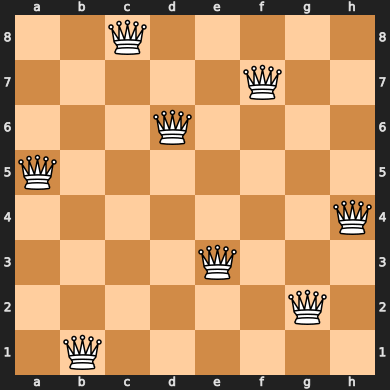

In [21]:
show_solution(Solution)

The 100 queens problem can be solved in 32 seconds if we do not use consistency checking.  

In [22]:
P = create_csp(1000)

In [ ]:
%%time
Solution = solve(P, False)

## Solving the *Zebra Puzzle*

In [ ]:
%run Zebra.ipynb

In [ ]:
zebra = zebra_csp()

In [ ]:
%%time
Solution = solve(zebra, True)

Solving the *Zebra Puzzle* takes about 4 seconds, provided we use consistency checking.

In [ ]:
show_solution(Solution)

## Solving a Sudoku Puzzle

In [ ]:
%run Sudoku.ipynb

In [ ]:
csp = sudoku_csp(Sudoku)
csp

Solving the given Sudoku puzzle takes about 2 minutes, provided we use consistency checking.  For hard problems, *local search* is not a good idea.

In [ ]:
%%time
Solution = solve(csp)

In [ ]:
show_solution(Solution)

## Solving a Crypto-Arithmetic Puzzle

In [ ]:
%run Crypto-Arithmetic.ipynb

In [ ]:
csp = crypto_csp()

Solving the crypto-arithmetic puzzle took 160 milliseconds with consistency checking.

In [ ]:
%%time
Solution = solve(csp, True)

In [ ]:
show_solution(Solution)